In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
#from mlxtend.frequent_patterns import apriori
from apyori import apriori 
from itertools import combinations, groupby
from collections import Counter
from Server_Assign import server_association
from format_rules import format_rules

In [2]:
#load data
# based off https://www.datatheque.com/posts/association-analysis/

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [4]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])

In [5]:
data=df[['Date', 'Src_IP', 'Dst_IP']]
#melt 
data2=data
data2=pd.melt(data2, id_vars=['Date'])

In [6]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)"
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)"
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)"
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)"
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)"


In [7]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
# Convert from DataFrame to a Series, with order_id as index and item_id as value
#necessary for assocation mining
data2=data2[['Date', 'value']]
data2.columns=['Date', 'IP']
data_series = data2.set_index('Date')['IP'].rename('IP')

type(data_series)

pandas.core.series.Series

In [8]:
data_series.loc['2017-08-02 00:00:00.419']# yes we get two results, 1 for source and 1 for destination

Date
2017-08-02 00:00:00.419    192.168.210.55
2017-08-02 00:00:00.419    192.168.100.11
Name: IP, dtype: object

In [9]:
#Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]   

In [10]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

Set minimum threshold to the same value used in the FP-Growth Model, for comparisoin. The FP-Growth wants the support in whole numbers, like it occurs '50' times in the dataset. Here, the Apriori wants the support in percent, like the pair makes up 1% of the dataset.

In [11]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'Duration': 'sum', 'Packets':'sum'}).reset_index())

pairs_count.columns=['pairs','frequency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [12]:
per_90=np.percentile(pairs_count['frequency'], [90])

min_support=per_90/len(df)

In [13]:
min_support=min_support[0]
min_support

3.24945345658779e-05

In [14]:
#run the model

rules = association_rules(data_series, min_support)  #0.001 is minimum support or that the IP address must appear in the requests 1% of time

Starting order_item:               16371984
Items with support >= 3.24945345658779e-05:            9041
Remaining order_item:              16371372
Remaining orders with 2+ items:     6709534
Remaining order_item:              16370809


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Item pairs:                           92273
Item pairs with support >= 3.24945345658779e-05:      17282



How many rules did we create?

In [15]:
len(rules)

17282

582 rules is not a lot, considering we have 44,000 unique pairs of IP addresses

In [16]:
rules.head()

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
6075,14218_62,14218_62,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063
11531,192.168.200.120,192.168.200.99,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063
11530,192.168.200.73,192.168.200.99,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063
11529,192.168.200.188,192.168.200.189,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063
3049,12914_60,12914_60,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063


(array([1.6911e+04, 2.7100e+02, 7.0000e+01, 1.7000e+01, 1.0000e+01,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.67212895e-06, 8.75015049e-02, 1.75001338e-01, 2.62501170e-01,
        3.50001003e-01, 4.37500836e-01, 5.25000669e-01, 6.12500502e-01,
        7.00000334e-01, 7.87500167e-01, 8.75000000e-01]),
 <a list of 10 Patch objects>)

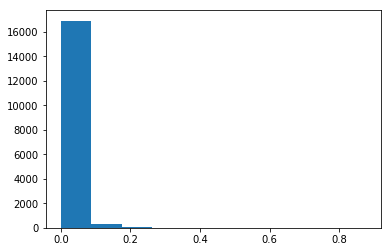

In [17]:
plt.hist(rules['confidenceAtoB'])

In [18]:
#The FP algorithm uses a confidence filter of 0.7 or 70%. However, this dataset has much lower confidence values.... and we will keep all values going forward.

In [25]:
rules[rules['confidenceAtoB']>=0.7]

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift,pairs,pairs2
3054,12916_236,12916_236,21,0.000313,24,0.000358,24,0.000358,0.875,0.875,2446.184271,"[12916_236, 12916_236]","(12916_236, 12916_236)"


In [20]:
rules_70=rules[rules['confidenceAtoB']>=0.7]
len(rules_70)

1

## Create Scheduler

In [26]:
#add back in the pairs column so we can match it up with our dataframe

rules['pairs']=list(zip(rules.item_A, rules.item_B))
rules['pairs']=rules['pairs'].apply(sorted)
rules['pairs2']=tuple(rules['pairs'])

In [27]:
pairs_count.head()

,pairs,frequency,total_duration,total_packets,norm_latency
0,"(0.0.0.0, 255.255.255.255)",123,6.801,223,0.000004
1,"(10000_163, 192.168.220.47)",16,6.378,204,0.000003
2,"(10000_34, 192.168.210.45)",96,23.679,723,0.000013
3,"(10000_34, 192.168.210.46)",165,28.699,971,0.000016
4,"(10000_34, 192.168.210.47)",433,77.542,1739,0.000042


In [28]:
rules.head()

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift,pairs,pairs2
6075,14218_62,14218_62,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[14218_62, 14218_62]","(14218_62, 14218_62)"
11531,192.168.200.120,192.168.200.99,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[192.168.200.120, 192.168.200.99]","(192.168.200.120, 192.168.200.99)"
11530,192.168.200.73,192.168.200.99,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[192.168.200.73, 192.168.200.99]","(192.168.200.73, 192.168.200.99)"
11529,192.168.200.188,192.168.200.189,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[192.168.200.188, 192.168.200.189]","(192.168.200.188, 192.168.200.189)"
3049,12914_60,12914_60,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[12914_60, 12914_60]","(12914_60, 12914_60)"


Assume we have enough servers to host each app (IP address), and each server can hold 20 apps. How many servers do we need?

In [29]:
apps_server=20
rules_df=rules.merge(pairs_count, left_on='pairs2', right_on='pairs')
rules_df=rules_df.drop('pairs_y', axis=1)
rules_df=rules_df.rename(columns={'pairs_x':'pairs'})
rules_df['latency_rank']=rules_df['frequency']*rules_df['norm_latency']

In [22]:
rules_df=rules_df.sort_values(by='latency_rank', ascending=False)
    
    #1. Start by filling in the servers on the pairs until the server is full
import math
pairs_server=apps_server/2 #pairs of IP addresses that can fit on each server

#how many servers do we need for our rules, which are in pairs?
servers_rule=math.ceil(len(rules_df)/pairs_server)
servers_rule_list=list(range(0,servers_rule+1))
servers_rule_list=np.repeat(servers_rule_list,pairs_server)

servers_rule_list=servers_rule_list[0:len(rules_df)]
    
    # add a pair_ID column so we can keep track of how frequently IP addresses repeat in different pairs
rules_df['pair_ID']=range(0, len(rules_df))
    
    #start by assigning the most important pair to a server
rules_df['server_A']=None
rules_df['server_B']=None
rules_df.loc[rules_df['pair_ID']==0, 'server_A'] = 0
rules_df.loc[rules_df['pair_ID']==0, 'server_B'] = 0
    
    #assign these servers to the pairs in our rules dataframe. Again this is stupid as we are not considering individual IPs that may repeat in different pairs. but it's a start
rules_df['server']=servers_rule_list
rules_df.index=range(0, len(rules_df))#ne


,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,...,pairs2,frequency,total_duration,total_packets,norm_latency,latency_rank,pair_ID,server_A,server_B,server
0,10008_9,192.168.210.55,4,0.000060,189662,2.826754,503956,7.511043,0.000021,0.000008,...,"(10008_9, 192.168.210.55)",173796,8622.761,8257508,0.004718,819.937865,0,0,0,0
1,10008_24,192.168.220.43,9,0.000134,10111,0.150696,345516,5.149627,0.000890,0.000026,...,"(10008_24, 192.168.220.43)",5526,192871.945,1119144,0.105527,583.142585,1,None,None,0
2,192.168.220.43,10008_24,9,0.000134,345516,5.149627,10111,0.150696,0.000026,0.000890,...,"(10008_24, 192.168.220.43)",5526,192871.945,1119144,0.105527,583.142585,2,None,None,0
3,192.168.220.51,DNS,94,0.001401,1794120,26.739860,995938,14.843624,0.000052,0.000094,...,"(192.168.220.51, DNS)",205930,2094.579,385538,0.001146,235.999554,3,None,None,0
4,DNS,192.168.220.51,98,0.001461,995938,14.843624,1794120,26.739860,0.000098,0.000055,...,"(192.168.220.51, DNS)",205930,2094.579,385538,0.001146,235.999554,4,None,None,0


In [32]:
rules_df.rename(columns={'item_A': 'IP_A', 'item_B' : 'IP_B'}, inplace=True)


In [33]:

rules_df.head()

,IP_A,IP_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift,pairs,pairs2,frequency,total_duration,total_packets,norm_latency,latency_rank
0,192.168.210.55,12257_28,4,0.000060,503956,7.511043,16,0.000238,0.000008,0.250000,0.033284,"[12257_28, 192.168.210.55]","(12257_28, 192.168.210.55)",8,0.621,16,3.397711e-07,0.000003
1,12257_28,192.168.210.55,4,0.000060,16,0.000238,503956,7.511043,0.250000,0.000008,0.033284,"[12257_28, 192.168.210.55]","(12257_28, 192.168.210.55)",8,0.621,16,3.397711e-07,0.000003
2,192.168.210.56,13049_193,76,0.001133,181815,2.709801,1775,0.026455,0.000418,0.042817,0.015801,"[13049_193, 192.168.210.56]","(13049_193, 192.168.210.56)",1775,79345.558,245786,4.341276e-02,77.057656
3,13049_193,192.168.210.56,76,0.001133,1775,0.026455,181815,2.709801,0.042817,0.000418,0.015801,"[13049_193, 192.168.210.56]","(13049_193, 192.168.210.56)",1775,79345.558,245786,4.341276e-02,77.057656
4,192.168.210.26,192.168.210.2,19,0.000283,12519,0.186585,12517,0.186555,0.001518,0.001518,0.008135,"[192.168.210.2, 192.168.210.26]","(192.168.210.2, 192.168.210.26)",33,0.000,33,0.000000e+00,0.000000


In [36]:
#assign servers
server_df, server_rules, latency_total, latency_model_total, avg_latency, avg_model_latency=server_association(rules_df, df, apps_server)


In [38]:
latency_total

2014119.5810000007

In [39]:
latency_model_total

1571052.887

In [43]:
(latency_total-latency_model_total)/latency_total

0.21998033194236666

In [40]:
server_rules

,IP,serverid
10001_213,10001_213,11.0
10003_226,10003_226,11.0
10008_10,10008_10,5.0
10008_16,10008_16,4.0
10008_24,10008_24,3.0
10008_33,10008_33,8.0
10008_9,10008_9,12.0
10012_14,10012_14,9.0
10013_238,10013_238,12.0
10016_175,10016_175,9.0


In [37]:
server_df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,Src_Server,Dst_Server,duration_pred
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0,1.0,0.003
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",1.0,0.0,0.000
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",1.0,1.0,0.000
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",NaN,1.0,0.000
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",1.0,1.0,0.000


In [ ]:
int(num_server)

We know we can only fit 20 apps on each server, so in terms of the rules dataframe this is 10 rows (because each row contains 2 apps).
Create a sequence that fills in the server number on the rules dataframe, then merge these servers into the entire dataset.

In [ ]:
#how many servers will we use for our rules
import math
pairs_server=apps_server/2

#how many servers do we need for our rules, which are in pairs?
servers_rule=math.ceil(len(rules)/pairs_server)

In [ ]:
servers_rule_list=list(range(0,servers_rule+1))
servers_rule_list=np.repeat(servers_rule_list,pairs_server)

#remove the extra items
servers_rule_list=servers_rule_list[0:len(rules)]

In [ ]:
rules['server']=servers_rule_list

In [ ]:
rules.tail(10)

In [ ]:
rules_A=rules[['item_A', 'server']]
rules_B=rules[['item_B', 'server']]
rules_A.columns=['item', 'server']
rules_B.columns=['item', 'server']

In [ ]:
rules_AB=pd.concat([rules_A, rules_B])

In [ ]:
rules_AB.head()

### merge in the servers from the rules to the  main dataframe

In [ ]:
df2=df


In [ ]:
df2=df2.merge(rules_AB, left_on='Src_IP', right_on='item', how='left') #creates a column that shows the server used for Src_IP


In [ ]:
df2=df2.rename(columns = {'server':'server_Src'})

In [ ]:
df2=df2.merge(rules_AB, left_on='Dst_IP', right_on='item', how='left') #creates a column that shows the server used for Src_IP
 #creates a column that shows the server used for Dst_IP, or 'itemB' in the rules

In [ ]:
df2=df2.rename(columns = {'server':'server_Dst'})


In [ ]:
df2=df2.drop(['item_y', 'item_x'], axis=1)

create new column with the predicted durationo. if servers are the same for the pair, set duration=0

In [ ]:
df2['duration_pred']=df2['Duration']
df2['duration_pred'][df2['server_Src']==df2['server_Dst']]=0

In [ ]:
#want to check that we do indeed have matching servers for the rules we created
df2[df2['server_Src']==df2['server_Dst']]

Sum up the originial duration times for latency, and compare that with our predicted latency times

In [ ]:
df2['Duration'].sum()

In [ ]:
df2['duration_pred'].sum()

% Difference:

In [ ]:
(df2['Duration'].sum()- df2['duration_pred'].sum())/ df2['Duration'].sum()

a 1% improvement

Now, fill in the rest of the servers based on random chance.